In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotly as plty
import seaborn as sn
import sklearn
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import tensorrt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


2023-07-07 21:32:41.937575: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-07 21:32:41.938836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-07 21:32:41.957395: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-07-07 21:32:41.957410: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-07-07 21:32:41.957420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1500] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Choose a memory limit for your GPU
memory_limit = 4 * 1024

# TF Memory Alloc Settings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2023-07-07 21:32:42.581288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 21:32:42.581526: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2141] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
'''
# Load Data
df = pd.read_csv("GSE85241_cellsystems_dataset_4donors_CorrectHeaders.csv", index_col=0)

# Normalize Data
df_nrmlzd = df.copy()
for column in tqdm(df_nrmlzd.columns):
    df_nrmlzd[column] = df_nrmlzd[column] / df_nrmlzd[column].abs().max()

df_nrmlzd.to_csv("GSE85241_cellsystems_dataset_4donors_CorrectHeaders_Normalized.csv")
'''

'\n# Load Data\ndf = pd.read_csv("GSE85241_cellsystems_dataset_4donors_CorrectHeaders.csv", index_col=0)\n\n# Normalize Data\ndf_nrmlzd = df.copy()\nfor column in tqdm(df_nrmlzd.columns):\n    df_nrmlzd[column] = df_nrmlzd[column] / df_nrmlzd[column].abs().max()\n\ndf_nrmlzd.to_csv("GSE85241_cellsystems_dataset_4donors_CorrectHeaders_Normalized.csv")\n'

In [4]:
# Read from normalized csv if already prepared
df_nrmlzd = pd.read_csv("GSE85241_cellsystems_dataset_4donors_CorrectHeaders_Normalized.csv", index_col=0)

# Shuffle and split data
df_nrmlzd = df_nrmlzd.sample(frac =1)
df_nrmlzd_test = df_nrmlzd.sample(frac = 0.20)
df_nrmlzd_train = df_nrmlzd.drop(df_nrmlzd_test.index)

# Convert dataframes to tensors
X_test = tf.convert_to_tensor(df_nrmlzd_test)
X_train = tf.convert_to_tensor(df_nrmlzd_train)

In [5]:
print("\n\033[1m\033[96mWhole dataset")
display(df_nrmlzd)
print("\n\033[1m\033[92mTest set")
display(df_nrmlzd_test)
print("\n\033[1m\033[94mTraining set")
display(df_nrmlzd_train)


Whole dataset


,A1BG-AS1__chr19,A1BG__chr19,A1CF__chr10,A2M-AS1__chr12,A2ML1__chr12,A2M__chr12,A4GALT__chr22,A4GNT__chr3,AAAS__chr12,AACSP1__chr5,...,ZWILCH__chr15,ZWINT__chr10,ZXDA__chrX,ZXDB__chrX,ZXDC__chr3,ZYG11A__chr1,ZYG11B__chr1,ZYX__chr7,ZZEF1__chr17,ZZZ3__chr1
D30-7_42,0.0,0.000000,0.073362,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.209602,0.113009,0.0,0.050243,0.027466,0.000000,0.033790
D30-7_8,0.0,0.000000,0.098009,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.067537,0.0,0.050243,0.000000,0.135959,0.000000
D28-3_21,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
D28-2_37,0.0,0.198428,0.048812,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.114143,0.0,0.000000,0.000000,0.158844,0.0,0.075513,0.000000,0.000000,0.067712
D31-6_38,0.0,0.000000,0.048812,0.49902,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.022424,0.0,0.025072,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D28-3_22,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
D30-1_7,0.0,0.000000,0.073362,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.044936,0.0,0.000000,0.000000,0.000000,0.000000
D29-7_68,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.330705,0.0,...,0.000000,0.0,0.198428,0.139460,0.090228,0.0,0.000000,0.000000,0.067712,0.000000
D28-1_25,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000



Test set


,A1BG-AS1__chr19,A1BG__chr19,A1CF__chr10,A2M-AS1__chr12,A2ML1__chr12,A2M__chr12,A4GALT__chr22,A4GNT__chr3,AAAS__chr12,AACSP1__chr5,...,ZWILCH__chr15,ZWINT__chr10,ZXDA__chrX,ZXDB__chrX,ZXDC__chr3,ZYG11A__chr1,ZYG11B__chr1,ZYX__chr7,ZZEF1__chr17,ZZZ3__chr1
D30-5_93,0.0,0.0,0.073362,0.0,0.0,0.0,0.0,0.0,0.165028,0.0,...,0.000000,0.0,0.000000,0.000000,0.158844,0.0,0.050243,0.000000,0.067712,0.067712
D30-3_58,0.0,0.0,0.024358,0.0,0.0,0.0,0.0,0.0,0.165028,0.0,...,0.000000,0.0,0.000000,0.069593,0.067537,0.0,0.100883,0.000000,0.067712,0.033790
D28-6_90,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
D30-7_10,0.0,0.0,0.024358,0.0,0.0,0.0,0.0,0.0,0.165028,0.0,...,0.056959,0.0,0.000000,0.000000,0.022424,0.0,0.025072,0.000000,0.000000,0.033790
D28-2_75,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.165028,0.0,...,0.000000,0.0,0.198428,0.280022,0.090228,0.0,0.100883,0.027466,0.033790,0.067712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D31-1_59,0.0,0.0,0.147599,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.069593,0.000000,0.0,0.100883,0.000000,0.000000,0.033790
D28-8_86,0.0,0.0,0.197587,0.0,0.0,0.0,0.0,0.0,0.497036,0.0,...,0.000000,0.0,0.000000,0.069593,0.113009,0.0,0.126354,0.055040,0.067712,0.033790
D30-5_23,0.0,0.0,0.048812,0.0,0.0,0.0,0.0,0.0,0.165028,0.0,...,0.000000,0.0,0.198428,0.139460,0.067537,0.0,0.025072,0.000000,0.000000,0.067712
D30-4_9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.056959,0.0,0.000000,0.000000,0.000000,0.0,0.025072,0.000000,0.067712,0.000000



Training set


,A1BG-AS1__chr19,A1BG__chr19,A1CF__chr10,A2M-AS1__chr12,A2ML1__chr12,A2M__chr12,A4GALT__chr22,A4GNT__chr3,AAAS__chr12,AACSP1__chr5,...,ZWILCH__chr15,ZWINT__chr10,ZXDA__chrX,ZXDB__chrX,ZXDC__chr3,ZYG11A__chr1,ZYG11B__chr1,ZYX__chr7,ZZEF1__chr17,ZZZ3__chr1
D30-7_42,0.0,0.0,0.073362,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.209602,0.113009,0.0,0.050243,0.027466,0.000000,0.03379
D30-7_8,0.0,0.0,0.098009,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.067537,0.0,0.050243,0.000000,0.135959,0.00000
D28-3_21,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
D31-6_38,0.0,0.0,0.048812,0.49902,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.022424,0.0,0.025072,0.000000,0.000000,0.00000
D28-4_72,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D29-6_28,0.0,0.0,0.098009,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.069593,0.067537,0.0,0.000000,0.000000,0.000000,0.00000
D31-1_28,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.069593,0.022424,0.0,0.025072,0.055040,0.000000,0.00000
D28-3_22,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
D29-7_68,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.330705,0.0,...,0.0,0.0,0.198428,0.139460,0.090228,0.0,0.000000,0.000000,0.067712,0.00000


In [6]:
# Implement the Auto-Encoder to reduce dimensionality
# Note: We see that the data is very sparse so a ReLU is used 
#       before the output layer to get the model to output mostly 0

# Note that `'my_package'` is used as the `package` argument here, and since
# the `name` argument is not provided, `'MyDense'` is used as the `name`.
@keras.saving.register_keras_serializable('my_package')
class Autoencoder(models.Model):
    def __init__(self, data_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Dense(
                8192,
                activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                bias_initializer=tf.keras.initializers.glorot_normal,
                kernel_initializer=tf.keras.initializers.glorot_normal
            ),
            layers.Dense(
                4096,
                activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                bias_initializer=tf.keras.initializers.glorot_normal,
                kernel_initializer=tf.keras.initializers.glorot_normal
            ),
            layers.Dense(self.latent_dim, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(
                4096,
                activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                bias_initializer=tf.keras.initializers.glorot_normal,
                kernel_initializer=tf.keras.initializers.glorot_normal
            ),
            layers.Dense(
                8192,
                activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                bias_initializer=tf.keras.initializers.glorot_normal,
                kernel_initializer=tf.keras.initializers.glorot_normal
            ),
            layers.Dense(
                self.data_dim,
                activation='relu',
                bias_initializer=tf.keras.initializers.glorot_normal,
                kernel_initializer=tf.keras.initializers.glorot_normal
            )
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


assert keras.saving.get_registered_object('my_package>Autoencoder') == Autoencoder
assert keras.saving.get_registered_name(Autoencoder) == 'my_package>Autoencoder'


# Results
You need to...
- Train AE on p=21 (from PCA)
- Generate Training curves
- Correlation matrices ON TEST DATA
- Reconstruction MSE and other metrics ON TEST DATA
- K-means clustering + visualization
- Compare K-mean clustering of the AE

### PCA Dimensions

In [7]:
### Training done in the experiment file 'experiment.py'

### Training Curves
Avg MSE across the k-folds for each of the p sizes trained all on one graph

In [8]:
# Automate the process (if the computer can...)
# for i in range(1,6):
#     # Load in Training Histories Okay... no training curves
#     with open("trainingHistory_2pow" + str(i) + ".pkl", "rb") as f: # "rb" because we want to read in binary mode
#          history = pickle.load(f)
            
#     # Get the full history across folds
#     full_history_MSE = history[0][0].history['mean_squared_error']\
#         + history[0][1].history['mean_squared_error']\
#         + history[0][2].history['mean_squared_error']\
#         + history[0][3].history['mean_squared_error']\
#         + history[0][4].history['mean_squared_error']
    
#     full_history_val_MSE = history[0][0].history['val_mean_squared_error']\
#         + history[0][1].history['val_mean_squared_error']\
#         + history[0][2].history['val_mean_squared_error']\
#         + history[0][3].history['val_mean_squared_error']\
#         + history[0][4].history['val_mean_squared_error']
    
#     # Load in the AE model
#     AEi = keras.models.load_model('AE_2pow' + str(i) + '.keras')
    
#     # Create plot and save
#     plt.plot(full_history_MSE, label='MSE')
#     plt.plot(full_history_val_MSE, label = 'val_MSE')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE')
#     plt.ylim([0, 0.01])
#     plt.legend(loc='lower right')
#     plt.title('Training MSE - Latent Dim = ' + str(2**i))
#     plt.savefig('Training_MSE_LDim_' + str(i) + '.png')
    
#     loss_test_AE, MSE_test_AE = AE.evaluate(X_test, X_test, verbose=2)
#     print("[" + str(2**i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [9]:
# i = 0

# # Load in Training Histories Okay... no training curves
# with open("trainingHistory_" + str(i) + ".pkl", "rb") as f: # "rb" because we want to read in binary mode
#     history = pickle.load(f)
#     f.close()
    
# # Get the full history across folds
# full_history_MSE = history[0][0].history['mean_squared_error']\
#     + history[0][1].history['mean_squared_error']\
#     + history[0][2].history['mean_squared_error']\
#     + history[0][3].history['mean_squared_error']\
#     + history[0][4].history['mean_squared_error']

# full_history_val_MSE = history[0][0].history['val_mean_squared_error']\
#     + history[0][1].history['val_mean_squared_error']\
#     + history[0][2].history['val_mean_squared_error']\
#     + history[0][3].history['val_mean_squared_error']\
#     + history[0][4].history['val_mean_squared_error']

# # Load in the AE model
# AEi = keras.models.load_model('AE_' + str(i) + '.keras')

# # Create plot and save
# plt.plot(full_history_MSE, label='MSE')
# plt.plot(full_history_val_MSE, label = 'val_MSE')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.ylim([0, 0.01])
# plt.legend(loc='lower right')
# plt.title('Training MSE - Latent Dim = ' + str(128 * 2 ** i))
# plt.savefig('Training_MSE_LDim_' + str(128 * 2 ** i) + '.png')

# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(128 * 2 ** i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

### Correlation Matrices
Using predictions on the test data

Include some stats

In [ ]:
# i = 21

# # # Load in the AE model
#AEi = keras.models.load_model('AE_' + str(i) + '.keras')

#code = AEi.encoder.predict(X_test)
#df_code = pd.DataFrame(
#    data = code,
#    columns = list(range(code.shape[1]))
#)

figure = plt.figure(figsize=(100, 60))
corrMatrix = df_nrmlzd.corr()
sn.heatmap(corrMatrix, annot=False)
plt.title('Correlation Matrix - Latent Dim = ' + str(19140))
plt.savefig('CorrMatrix_19k.png')
plt.close(figure)

### Reconstruction MSE 
and other metrics on TEST DATA

###### i = 0
# AEi = keras.models.load_model('AE_' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(128 * 2 ** i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [12]:
# i = 1
# AEi = keras.models.load_model('AE_' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(128 * 2 ** i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [13]:
# i = 2
# AEi = keras.models.load_model('AE_' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(128 * 2 ** i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [14]:
# i = 3
# AEi = keras.models.load_model('AE_' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(128 * 2 ** i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [15]:
# i = 4
# AEi = keras.models.load_model('AE_' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(128 * 2 ** i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [16]:
# i = 5
# AEi = keras.models.load_model('AE_' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(128 * 2 ** i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [17]:
# i = 1
# AEi = keras.models.load_model('AE_2pow' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(2**i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [18]:
# i = 2
# AEi = keras.models.load_model('AE_2pow' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(2**i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [19]:
# i = 3
# AEi = keras.models.load_model('AE_2pow' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(2**i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [20]:
# i = 4
# AEi = keras.models.load_model('AE_2pow' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(2**i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

In [21]:
# i = 5
# AEi = keras.models.load_model('AE_2pow' + str(i) + '.keras')
# loss_test_AE, MSE_test_AE = AEi.evaluate(X_test, X_test, verbose=2)
# print("[" + str(2**i) + "] Test Loss: {}\nTest MSE: {}".format(loss_test_AE, MSE_test_AE))

### k-Means Clustering
Of the encoded datasets + a visualization

In [22]:
# Imports
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

In [26]:
# Display Test Data
display(X_test)

<tf.Tensor: shape=(614, 19140), dtype=float64, numpy=
array([[0.        , 0.        , 0.07336184, ..., 0.        , 0.06771177,
        0.06771177],
       [0.        , 0.        , 0.02435799, ..., 0.        , 0.06771177,
        0.0337895 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.04881168, ..., 0.        , 0.        ,
        0.06771177],
       [0.        , 0.        , 0.        , ..., 0.        , 0.06771177,
        0.        ],
       [0.        , 0.        , 0.02435799, ..., 0.02746595, 0.06771177,
        0.        ]])>

In [23]:
# Load in 4 models to compare
AE4096 = keras.models.load_model('AE_5.keras')
AE512 = keras.models.load_model('AE_2.keras')
AE21 = keras.models.load_model('AE_21.keras')
AE16 = keras.models.load_model('AE_2pow4.keras')

In [24]:
# Compress X_test Data 
X_test_4096 = AE4096.encoder.predict(X_test)
X_test_512 = AE512.encoder.predict(X_test)
X_test_21 = AE21.encoder.predict(X_test)
X_test_16 = AE16.encoder.predict(X_test)

20/20 [==============================] - 0s 17ms/step


Num Clusters = 2
Silhouette Score = 0.5771
----------------------------
Num Clusters = 3
Silhouette Score = 0.3557
----------------------------
Num Clusters = 4
Silhouette Score = 0.3972
----------------------------
Num Clusters = 5
Silhouette Score = 0.4092
----------------------------
Num Clusters = 6
Silhouette Score = 0.4118
----------------------------
Num Clusters = 7
Silhouette Score = 0.3829
----------------------------


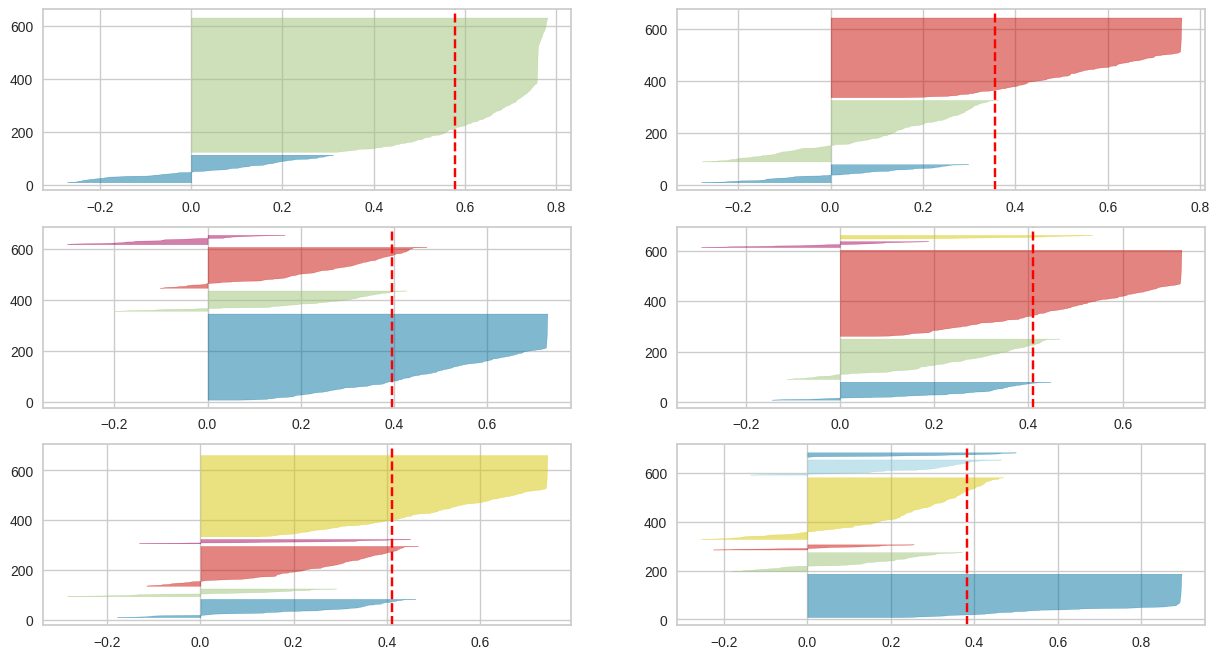

In [34]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:

    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=100,
                random_state=42)

    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_test_16)

    print(f"Num Clusters = {i}")
    print(f"Silhouette Score = {visualizer.silhouette_score_:0.4f}")
    print("----------------------------")

/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

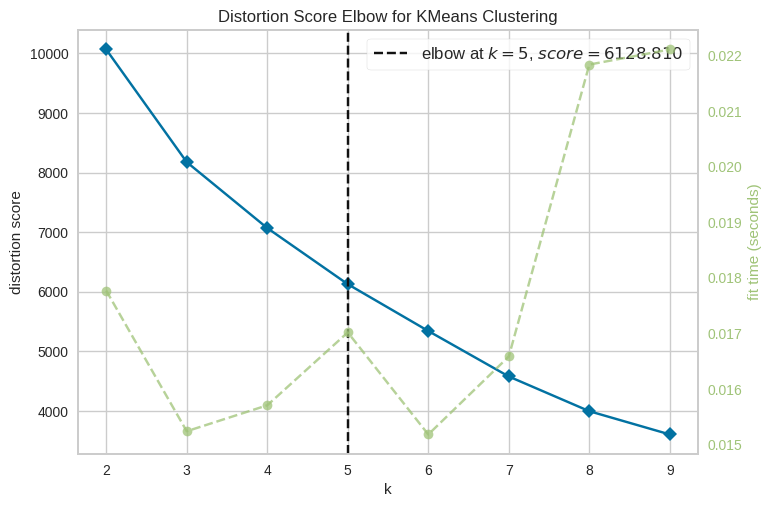

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(X_test_16)
visualizer.show()

Num Clusters = 2
Silhouette Score = 0.5928
----------------------------
Num Clusters = 3
Silhouette Score = 0.3767
----------------------------
Num Clusters = 4
Silhouette Score = 0.3975
----------------------------
Num Clusters = 5
Silhouette Score = 0.4099
----------------------------
Num Clusters = 6
Silhouette Score = 0.4242
----------------------------
Num Clusters = 7
Silhouette Score = 0.3980
----------------------------


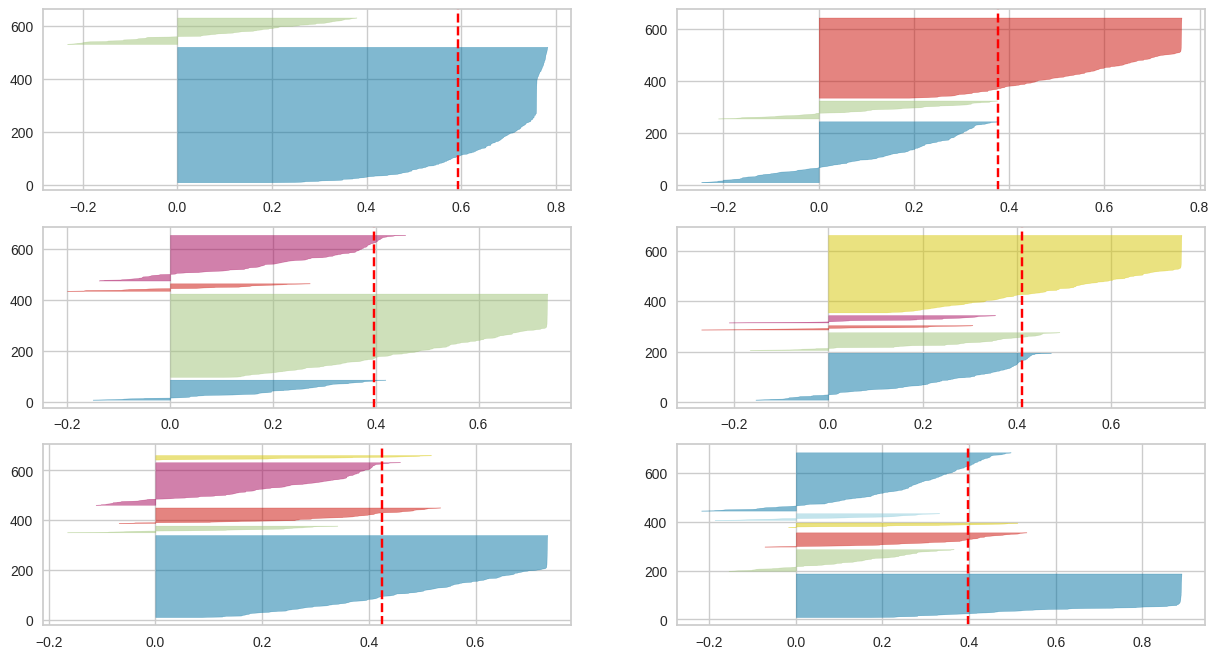

In [35]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:

    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=100,
                random_state=42)

    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_test_21)

    print(f"Num Clusters = {i}")
    print(f"Silhouette Score = {visualizer.silhouette_score_:0.4f}")
    print("----------------------------")

/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

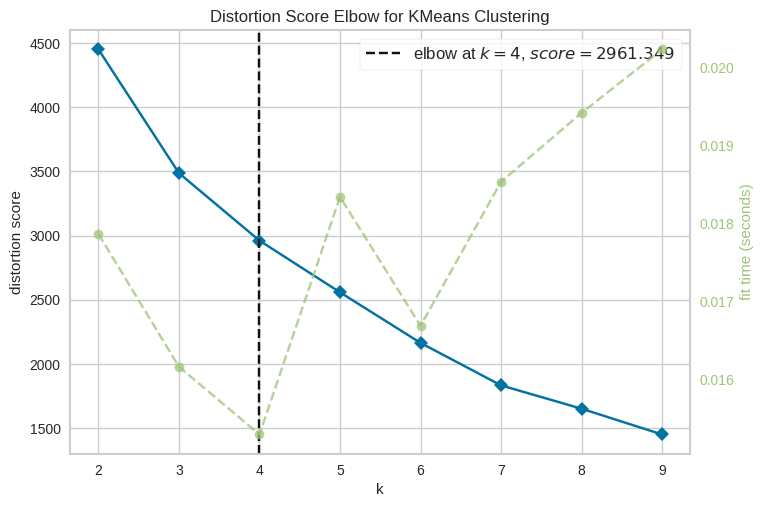

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(X_test_21)
visualizer.show()

Num Clusters = 2
Silhouette Score = 0.5403
----------------------------
Num Clusters = 3
Silhouette Score = 0.3290
----------------------------
Num Clusters = 4
Silhouette Score = 0.3330
----------------------------
Num Clusters = 5
Silhouette Score = 0.3333
----------------------------
Num Clusters = 6
Silhouette Score = 0.3352
----------------------------
Num Clusters = 7
Silhouette Score = 0.3515
----------------------------


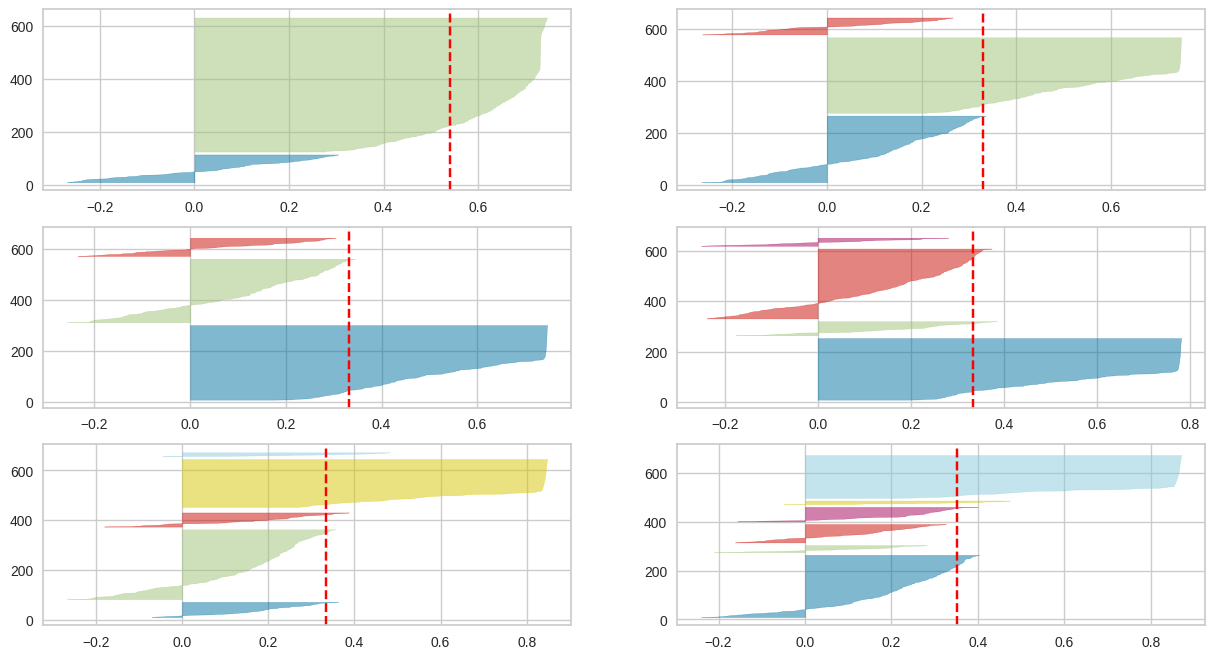

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:

    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=100,
                random_state=42)

    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_test_512)

    print(f"Num Clusters = {i}")
    print(f"Silhouette Score = {visualizer.silhouette_score_:0.4f}")
    print("----------------------------")

/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

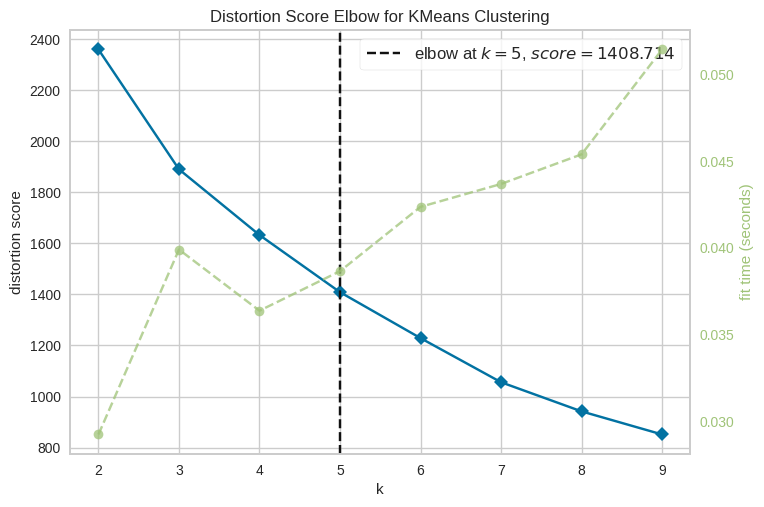

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(X_test_512)
visualizer.show()

Num Clusters = 2
Silhouette Score = 0.5660
----------------------------
Num Clusters = 3
Silhouette Score = 0.3126
----------------------------
Num Clusters = 4
Silhouette Score = 0.2898
----------------------------
Num Clusters = 5
Silhouette Score = 0.2830
----------------------------
Num Clusters = 6
Silhouette Score = 0.2572
----------------------------
Num Clusters = 7
Silhouette Score = 0.2862
----------------------------


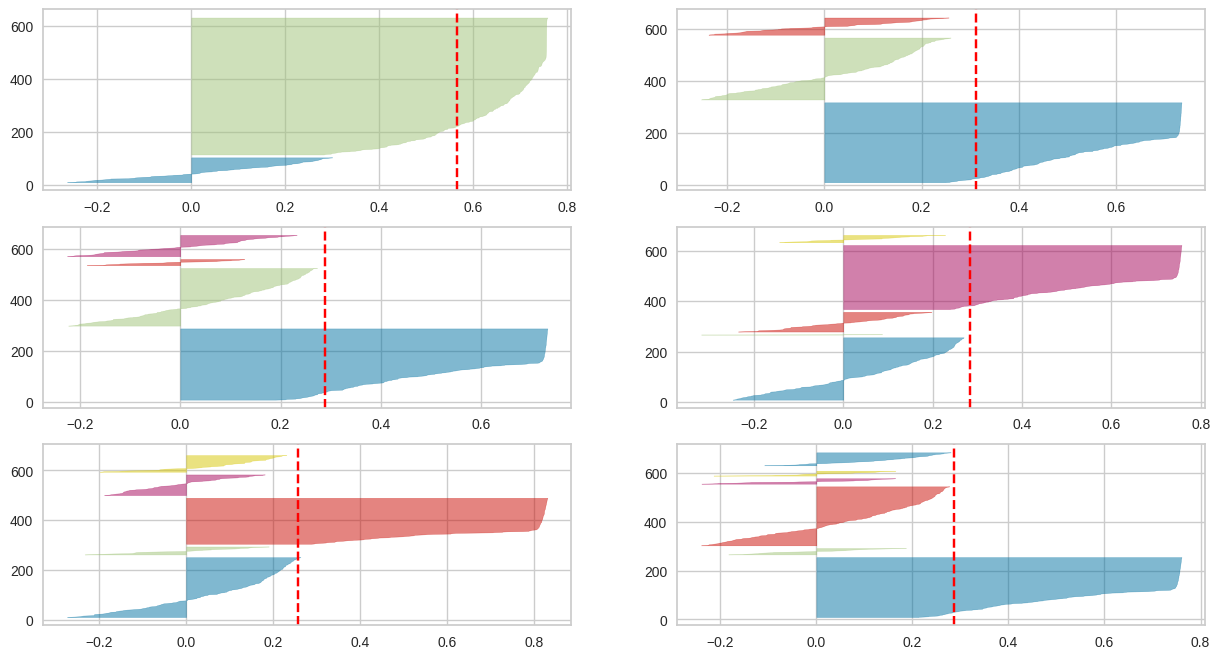

In [37]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:

    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=100,
                random_state=42)

    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_test_4096)

    print(f"Num Clusters = {i}")
    print(f"Silhouette Score = {visualizer.silhouette_score_:0.4f}")
    print("----------------------------")

/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/spencer/anaconda3/envs/DNN/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

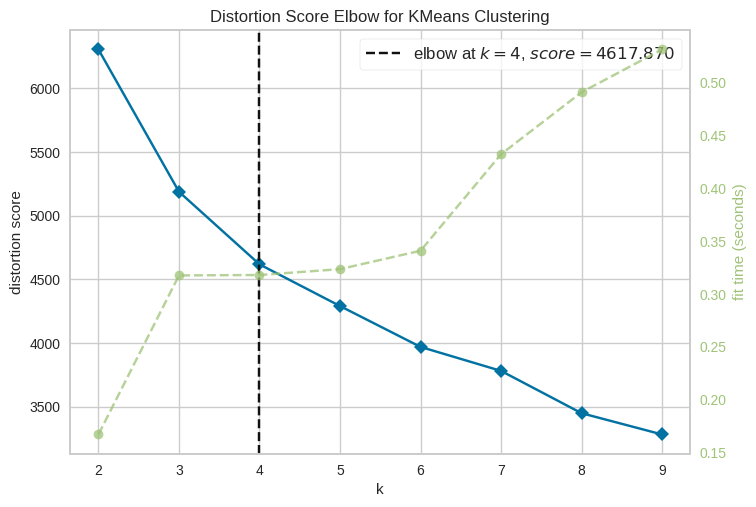

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(X_test_4096)
visualizer.show()